
# LLM Annotation Pairwise Analysis (Span Text Overlap)

This notebook computes **pairwise agreement metrics** between multiple LLMs' annotation JSON files by matching spans using **word-overlap Jaccard** similarity. It also visualizes:
- Histograms of **Jaccard** and **F1** scores
- **Span length** distributions overlayed by model
- **Subcategory** frequency bar charts by model

## How to use
1. Place your model JSON files in this environment (they are typically available in `/mnt/data`).  
2. Update the `JSON_GLOBS` cell (or leave as-is to auto-detect `*.json` in `/mnt/data`).  
3. Run all cells top-to-bottom.
4. Outputs (CSVs and PNGs) are saved under `results/`.

### JSON expected structure (per file)
A file should be a list of article objects. Each article may contain an `"annotations"` list, where each item includes at least:
```json
{
  "category": "Inflammatory Language",
  "subcategory": "hyperbole",
  "text": "some span text here ..."
}
```
Additional fields (title/topic/source/etc.) are ignored for matching.


In [ ]:

# %% [markdown]
# ## 0. Imports & Config

# %%
import os, glob, json, math, itertools, statistics
from pathlib import Path
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib style is intentionally default (no seaborn, no explicit colors).

# --- Config ---
DATA_DIR = Path('/content/data')        # where your JSONs live by default
OUT_DIR = Path('results')           # where to save CSVs/plots
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Glob(s) to find your JSONs. You can put explicit filenames if you prefer.
JSON_GLOBS = ['*.json']  # searched within DATA_DIR

# Matching parameters
MIN_JACCARD = 0.5         # minimum word-overlap Jaccard to consider a match
SAME_CATEGORY_REQUIRED = False  # set True to only match spans with same 'category'

# Tokenization parameters
WORD_RE = r"[A-Za-z0-9']+"  # basic token definition for word-level matching
STOPWORDS = set()           # optional: add stopwords if desired (kept empty by default)

print('CONFIG: MIN_JACCARD=', MIN_JACCARD,
      'SAME_CATEGORY_REQUIRED=', SAME_CATEGORY_REQUIRED,
      'DATA_DIR=', DATA_DIR)


CONFIG: MIN_JACCARD= 0.5 SAME_CATEGORY_REQUIRED= False DATA_DIR= /content/data


In [ ]:

# %% [markdown]
# ## 1. Discover JSON files

# %%
def discover_jsons(data_dir: Path, patterns):
    files = []
    for pat in patterns:
        files.extend((data_dir).glob(pat))
    files = [f for f in files if f.is_file() and f.suffix.lower()=='.json']
    return sorted(files)

json_paths = discover_jsons(DATA_DIR, JSON_GLOBS)
if not json_paths:
    print('No JSON files found in', DATA_DIR, 'with patterns', JSON_GLOBS)
else:
    print('Found JSON files:')
    for p in json_paths:
        print('  -', p.name)


Found JSON files:
  - GPT-5-mini-2.json
  - gpt-5.json


In [ ]:

# %% [markdown]
# ## 2. Load & Normalize annotations

# %%
import re

def normalize_model_name(path: Path) -> str:
    return path.stem

def tokenize(text: str):
    tokens = re.findall(WORD_RE, (text or '').lower())
    return [t for t in tokens if t not in STOPWORDS]

def word_set(text: str):
    return set(tokenize(text))

def jaccard(a_set, b_set):
    if not a_set and not b_set:
        return 1.0
    if not a_set or not b_set:
        return 0.0
    inter = len(a_set & b_set)
    union = len(a_set | b_set)
    return inter / union if union else 0.0

def load_annotations(path: Path):
    data = json.loads(path.read_text())
    model = normalize_model_name(path)
    rows = []
    for i, article in enumerate(data if isinstance(data, list) else []):
        anns = article.get('annotations') or []
        for ann in anns:
            txt = ann.get('text', '')
            cat = ann.get('category', None)
            sub = ann.get('subcategory', None)
            ws = word_set(txt)
            rows.append({
                'model': model,
                'article_idx': i,
                'category': cat,
                'subcategory': sub,
                'text': txt,
                'word_count': len(ws),
                'word_set': ws,
            })
    return rows

all_rows = []
for p in json_paths:
    try:
        all_rows.extend(load_annotations(p))
    except Exception as e:
        print('Failed to load', p, '->', e)

ann_df = pd.DataFrame(all_rows)
print('Total spans loaded:', len(ann_df))
ann_df.head()


Total spans loaded: 6022


,model,article_idx,category,subcategory,text,word_count,word_set
0,GPT-5-mini-2,0,Persuasive Propaganda,exaggeration,Brad Stephens will be able to deliver for his ...,13,"{be, will, for, able, to, on, brad, deliver, s..."
1,GPT-5-mini-2,0,Persuasive Propaganda,bandwagon,His deep knowledge of state policy and its imp...,15,"{deep, be, valuable, will, local, communities,..."
2,GPT-5-mini-2,0,Persuasive Propaganda,slogans,We will do whatever it takes to win,8,"{will, it, whatever, to, takes, we, win, do}"
3,GPT-5-mini-2,1,Persuasive Propaganda,exaggeration,"Sperm banks could one day be set up in space, ...",13,"{predicted, be, have, could, sperm, in, day, o..."
4,GPT-5-mini-2,1,Persuasive Propaganda,casual oversimplification,frozen sperm could be sent into space,7,"{be, could, sperm, frozen, into, sent, space}"


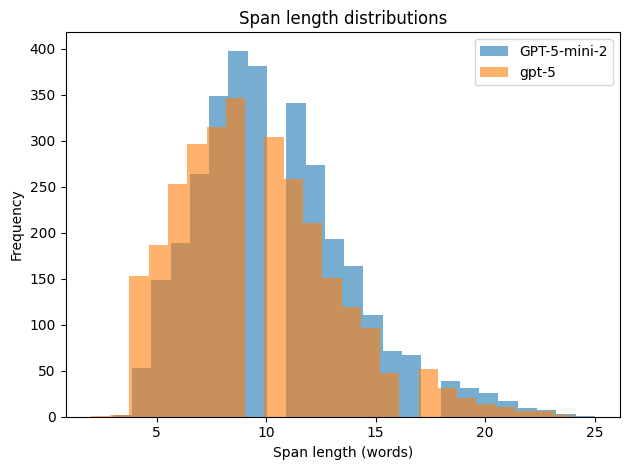

In [ ]:

# %% [markdown]
# ## 3. Span length distributions (overlayed by model)

# %%
def plot_span_length_overlay(df, out_path: Path):
    plt.figure()
    for model, subdf in df.groupby('model'):
        plt.hist(subdf['word_count'].values, bins=25, alpha=0.6, label=model)
    plt.title('Span length distributions')
    plt.xlabel('Span length (words)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

if not ann_df.empty:
    plot_span_length_overlay(ann_df, OUT_DIR / 'span_length_overlay.png')


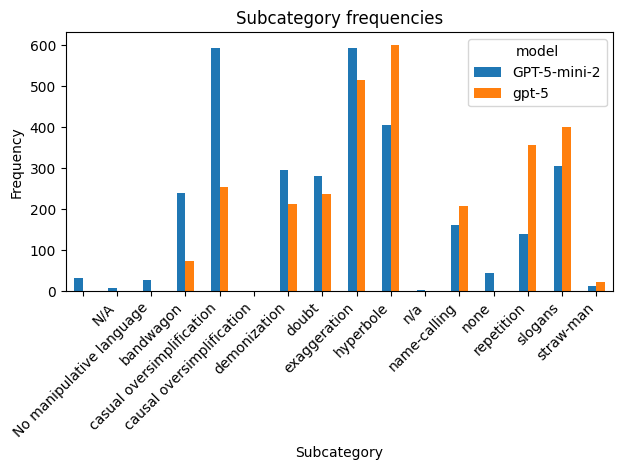

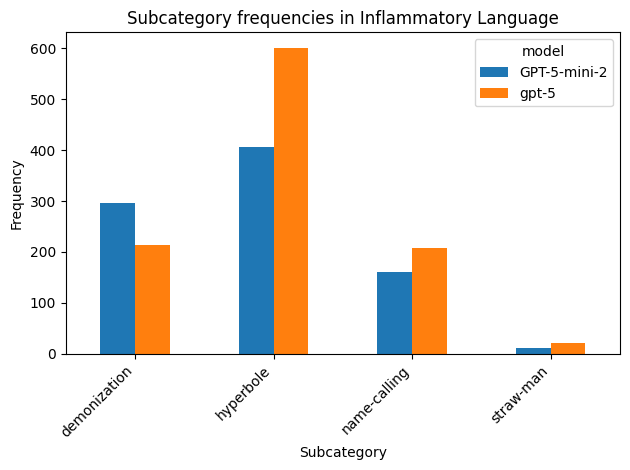

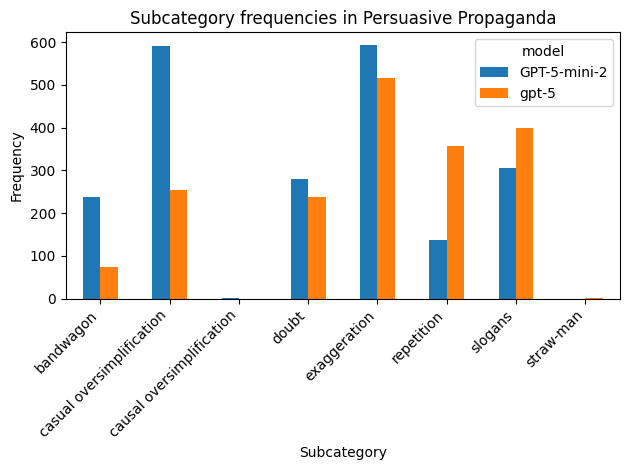

In [ ]:

# %% [markdown]
# ## 4. Subcategory frequencies per model

# %%
def plot_subcategory_by_model(df, category_filter=None, top_n=None, out_path: Path = None):
    subset = df.copy()
    if category_filter:
        subset = subset[subset['category'] == category_filter]
    counts = subset.groupby(['model','subcategory']).size().reset_index(name='freq')
    pivot = counts.pivot(index='subcategory', columns='model', values='freq').fillna(0).astype(int)
    if top_n:
        pivot = pivot.sort_values(pivot.columns.tolist(), ascending=False).head(top_n)
    ax = pivot.plot(kind='bar')
    ax.set_title(f"Subcategory frequencies{(' in ' + category_filter) if category_filter else ''}")
    ax.set_xlabel('Subcategory')
    ax.set_ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path)
    plt.show()
    return pivot

if not ann_df.empty:
    _pivot_all = plot_subcategory_by_model(ann_df, out_path=OUT_DIR / 'subcategory_freq_all.png')

    categories_to_plot = ['Inflammatory Language', 'Persuasive Propaganda']
    for cat in categories_to_plot:
        if cat in set(ann_df['category'].dropna().unique()):
            fname = f"subcategory_freq_{cat.lower().replace(' ', '_')}.png"
            _pivot_cat = plot_subcategory_by_model(
                ann_df,
                category_filter=cat,
                out_path=OUT_DIR / fname
            )


In [ ]:

# %% [markdown]
# ## 5. Pairwise matching & metrics (Jaccard, Precision/Recall/F1)

# %%
def greedy_match(spans_a, spans_b, min_overlap=0.5, same_category=False):
    """
    Match spans if they share at least `min_overlap` proportion of words in BOTH directions.
    E.g., 'the apple is red' matches 'the apple is red and round' since 3/4 overlap >= 0.5.
    """
    pairs = []
    for i, a in enumerate(spans_a):
        for j, b in enumerate(spans_b):
            if same_category and a['category'] != b['category']:
                continue

            a_words = a['word_set']
            b_words = b['word_set']
            if not a_words or not b_words:
                continue

            inter = len(a_words & b_words)
            overlap_a = inter / len(a_words)
            overlap_b = inter / len(b_words)
            overlap = min(overlap_a, overlap_b)

            if overlap >= min_overlap:
                pairs.append((i, j, overlap))

    # greedy non-conflicting matches, preferring higher overlap
    pairs.sort(key=lambda t: t[2], reverse=True)
    used_a = set()
    used_b = set()
    matches = []
    for i, j, score in pairs:
        if i in used_a or j in used_b:
            continue
        used_a.add(i)
        used_b.add(j)
        matches.append((i, j, score))
    return matches


def metrics_from_matches(n_a, n_b, matches):
    tp = len(matches)
    fp = n_b - tp  # B as predictions vs A
    fn = n_a - tp
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    f1        = (2*precision*recall / (precision + recall)) if (precision + recall) else 0.0
    return {'tp': tp, 'fp': fp, 'fn': fn, 'precision': precision, 'recall': recall, 'f1': f1}

def pairwise_compare(df, min_jaccard=0.5, same_category=False):
    results = []
    jaccard_hist = []
    models = sorted(df['model'].unique())
    for a, b in itertools.combinations(models, 2):
        df_a = df[df['model']==a]
        df_b = df[df['model']==b]
        all_matches = []
        for art in sorted(set(df_a['article_idx']).union(set(df_b['article_idx']))):
            spans_a = df_a[df_a['article_idx']==art].to_dict('records')
            spans_b = df_b[df_b['article_idx']==art].to_dict('records')
            if not spans_a or not spans_b:
                continue
            matches = greedy_match(spans_a, spans_b, min_jaccard, same_category)
            all_matches.extend([m[2] for m in matches])
        spans_a_all = df_a.to_dict('records')
        spans_b_all = df_b.to_dict('records')
        matches_global = greedy_match(spans_a_all, spans_b_all, min_jaccard, same_category)
        met_ab = metrics_from_matches(len(spans_a_all), len(spans_b_all), matches_global)
        met_ba = metrics_from_matches(len(spans_b_all), len(spans_a_all), matches_global)
        res = {
            'Model_A': a, 'Model_B': b,
            'A_spans': len(spans_a_all), 'B_spans': len(spans_b_all),
            'matched_pairs': len(matches_global),
            'mean_matched_jaccard': (sum([m[2] for m in matches_global]) / len(matches_global)) if matches_global else 0.0,
            'A_as_truth_precision': met_ab['precision'],
            'A_as_truth_recall': met_ab['recall'],
            'A_as_truth_f1': met_ab['f1'],
            'B_as_truth_precision': met_ba['precision'],
            'B_as_truth_recall': met_ba['recall'],
            'B_as_truth_f1': met_ba['f1'],
        }
        results.append(res)
        jaccard_hist.append({'pair': f'{a} vs {b}', 'jaccards': all_matches})
    return pd.DataFrame(results), jaccard_hist

pair_df, jhist = pairwise_compare(ann_df, MIN_JACCARD, SAME_CATEGORY_REQUIRED)
pair_df.to_csv(OUT_DIR / 'pairwise_metrics_summary.csv', index=False)
pair_df


,Model_A,Model_B,A_spans,B_spans,matched_pairs,mean_matched_jaccard,A_as_truth_precision,A_as_truth_recall,A_as_truth_f1,B_as_truth_precision,B_as_truth_recall,B_as_truth_f1
0,GPT-5-mini-2,gpt-5,3139,2883,1728,0.858026,0.599376,0.550494,0.573896,0.550494,0.599376,0.573896


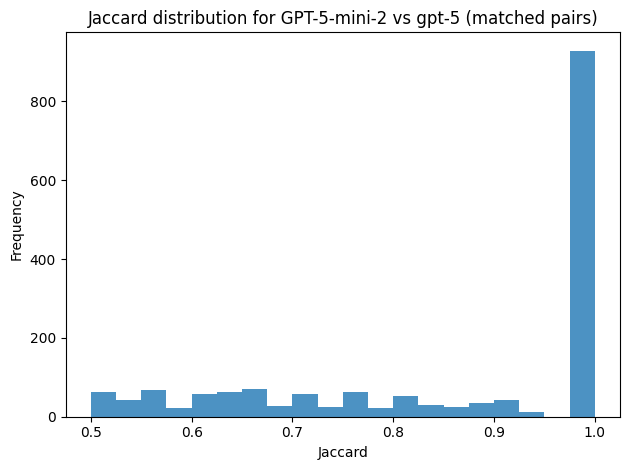

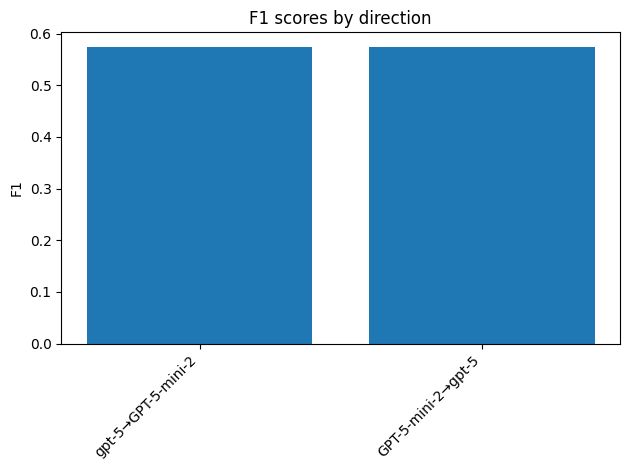

In [ ]:

# %% [markdown]
# ## 6. Histograms of Jaccard (matched pairs) and F1

# %%
def plot_jaccard_histograms(jhist, out_dir: Path):
    for entry in jhist:
        pair = entry['pair']
        vals = entry['jaccards']
        if not vals:
            continue
        plt.figure()
        plt.hist(vals, bins=20, alpha=0.8)
        plt.title(f'Jaccard distribution for {pair} (matched pairs)')
        plt.xlabel('Jaccard')
        plt.ylabel('Frequency')
        plt.tight_layout()
        fname = out_dir / f'jaccard_hist_{pair.replace(" ", "_").replace("/", "-")}.png'
        plt.savefig(fname)
        plt.show()

def plot_f1_hist(pair_df: pd.DataFrame, out_path: Path):
    melt = pair_df.melt(
        id_vars=['Model_A','Model_B'],
        value_vars=['A_as_truth_f1','B_as_truth_f1'],
        var_name='direction', value_name='f1'
    )
    plt.figure()
    labels = []
    vals = []
    for _, row in melt.iterrows():
        if row['direction']=='A_as_truth_f1':
            labels.append(f"{row['Model_B']}→{row['Model_A']}")
        else:
            labels.append(f"{row['Model_A']}→{row['Model_B']}")
        vals.append(row['f1'])
    x = np.arange(len(vals))
    plt.bar(x, vals)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.title('F1 scores by direction')
    plt.ylabel('F1')
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

plot_jaccard_histograms(jhist, OUT_DIR)
if not pair_df.empty:
    plot_f1_hist(pair_df, OUT_DIR / 'f1_by_direction.png')


In [ ]:

# %% [markdown]
# ## 7. Per-subcategory agreement (optional)

# %%
def per_subcategory_pairwise(df, min_jaccard=0.5, same_category=False):
    rows = []
    models = sorted(df['model'].unique())
    for a, b in itertools.combinations(models, 2):
        for subcat in sorted(df['subcategory'].dropna().unique()):
            df_sub = df[df['subcategory']==subcat]
            df_a = df_sub[df_sub['model']==a]
            df_b = df_sub[df_sub['model']==b]
            spans_a = df_a.to_dict('records')
            spans_b = df_b.to_dict('records')
            if not spans_a or not spans_b:
                continue
            matches = greedy_match(spans_a, spans_b, min_jaccard, same_category)
            met_ab = metrics_from_matches(len(spans_a), len(spans_b), matches)
            rows.append({
                'Model_A': a, 'Model_B': b, 'subcategory': subcat,
                'A_spans': len(spans_a), 'B_spans': len(spans_b),
                'matched_pairs': len(matches),
                'precision': met_ab['precision'], 'recall': met_ab['recall'], 'f1': met_ab['f1'],
            })
    out = pd.DataFrame(rows)
    if not out.empty:
        out.to_csv(OUT_DIR / 'per_subcategory_pairwise.csv', index=False)
    return out

per_subcat_df = per_subcategory_pairwise(ann_df, MIN_JACCARD, SAME_CATEGORY_REQUIRED)
per_subcat_df.head() if not per_subcat_df.empty else 'No overlapping subcategories across models to report.'


,Model_A,Model_B,subcategory,A_spans,B_spans,matched_pairs,precision,recall,f1
0,GPT-5-mini-2,gpt-5,bandwagon,238,74,37,0.500000,0.155462,0.237179
1,GPT-5-mini-2,gpt-5,casual oversimplification,592,253,102,0.403162,0.172297,0.241420
2,GPT-5-mini-2,gpt-5,demonization,296,213,108,0.507042,0.364865,0.424361
3,GPT-5-mini-2,gpt-5,doubt,280,237,86,0.362869,0.307143,0.332689
4,GPT-5-mini-2,gpt-5,exaggeration,593,515,168,0.326214,0.283305,0.303249


In [ ]:

# %% [markdown]
# ## 8. Export flattened spans

# %%
flat = ann_df.drop(columns=['word_set']).copy()
flat.to_csv(OUT_DIR / 'all_spans_flat.csv', index=False)
print('Wrote', OUT_DIR / 'all_spans_flat.csv')


Wrote results/all_spans_flat.csv
